# **Web Scraper with Machine Learning Integration**

## **Setup and Imports**

In [59]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import time

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Web Scraping**

Scraping reviews and ratings from "Books to Scrape" (safe test site)

In [60]:
# Scraping book reviews and ratings
base_url = 'http://books.toscrape.com/catalogue/page-{}.html'
reviews = []
ratings = []

headers = {'User-Agent': 'Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)'}

for page in range(1, 6):  # Scraping 5 pages
    url = base_url.format(page)
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    books = soup.find_all('article', class_='product_pod')

    for book in books:
        title = book.h3.a['title']
        rating_class = book.p['class'][1]
        rating = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5}.get(rating_class, 0)

        reviews.append(title)
        ratings.append(rating)

    time.sleep(1)  # polite delay

# Create DataFrame
df = pd.DataFrame({'Review': reviews, 'Rating': ratings})
df.head()


,Review,Rating
0,A Light in the Attic,3
1,Tipping the Velvet,1
2,Soumission,1
3,Sharp Objects,4
4,Sapiens: A Brief History of Humankind,5


## **Preprocess the Text**

In [61]:
# Cleaning text function
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Removing non-alphabetic
    text = text.lower()
    words = text.split()
    words = [w for w in words if w not in stopwords.words('english')]
    return " ".join(words)

# Applying cleaning
df['Clean_Review'] = df['Review'].apply(clean_text)
df.head


,Review,Rating,Clean_Review
0,A Light in the Attic,3,light attic
1,Tipping the Velvet,1,tipping velvet
2,Soumission,1,soumission
3,Sharp Objects,4,sharp objects
4,Sapiens: A Brief History of Humankind,5,sapiens brief history humankind


## **Create Features and Labels**

In [62]:
# Create sentiment label: Positive (1) if rating >=4, else Negative (0)

df['Sentiment'] = df['Rating'].apply(lambda x: 1 if x >= 4 else 0)

# TF-IDF feature extraction

tfidf = TfidfVectorizer(max_features=500)
X = tfidf.fit_transform(df['Clean_Review']).toarray()
y = df['Sentiment']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


## **Machine Learning Model Building**

#### Sentiment Analysis (Classification)

In [63]:
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost Classifier": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Support Vector Machine": SVC()
}

# Training and evaluate

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_val, y_pred))
    print("="*60)


Model: Logistic Regression
Accuracy: 0.7000
Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82        14
           1       0.00      0.00      0.00         6

    accuracy                           0.70        20
   macro avg       0.35      0.50      0.41        20
weighted avg       0.49      0.70      0.58        20

Model: Random Forest
Accuracy: 0.7000
Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82        14
           1       0.00      0.00      0.00         6

    accuracy                           0.70        20
   macro avg       0.35      0.50      0.41        20
weighted avg       0.49      0.70      0.58        20

Model: XGBoost Classifier
Accuracy: 0.7000
Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82        14
           1       0.00      0.00      0.00

# Clustering

KMeans Clustering on the Reviews

In [66]:
from sklearn.cluster import KMeans

# Apply KMeans Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)  # X is your TF-IDF feature matrix
df['Cluster'] = kmeans.labels_



Visualize Cluster Distribution

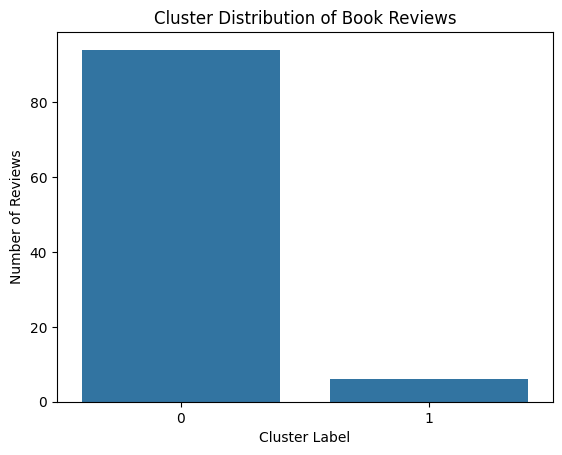

In [67]:
# Plot the number of reviews in each cluster
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Cluster', data=df)
plt.title("Cluster Distribution of Book Reviews")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Reviews")
plt.show()


Checking What's Inside Each Cluster

In [68]:

for cluster in range(2):
    print(f"\nSample reviews from Cluster {cluster}:")
    sample_reviews = df[df['Cluster'] == cluster]['Review'].head(5).values
    for review in sample_reviews:
        print(f"- {review}")



Sample reviews from Cluster 0:
- A Light in the Attic
- Tipping the Velvet
- Soumission
- Sharp Objects
- Sapiens: A Brief History of Humankind

Sample reviews from Cluster 1:
- Rat Queens, Vol. 3: Demons (Rat Queens (Collected Editions) #11-15)
- Princess Jellyfish 2-in-1 Omnibus, Vol. 01 (Princess Jellyfish 2-in-1 Omnibus #1)
- Outcast, Vol. 1: A Darkness Surrounds Him (Outcast #1)
- Lumberjanes, Vol. 2: Friendship to the Max (Lumberjanes #5-8)
- Lumberjanes, Vol. 1: Beware the Kitten Holy (Lumberjanes #1-4)


BONUS Visualization — PCA 2D Plot

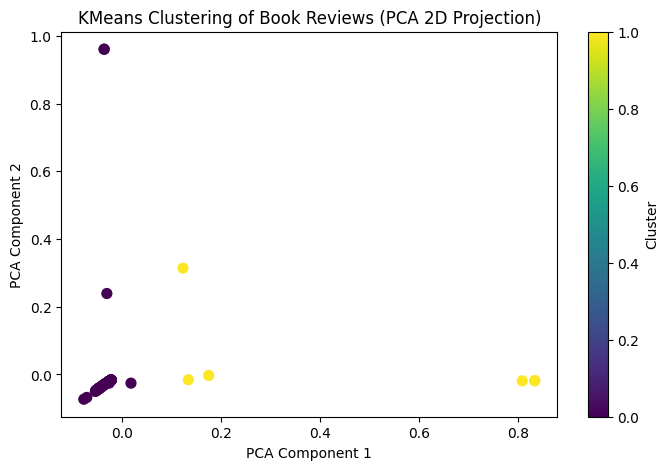

In [69]:
# Reduce to 2 dimensions using PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the clusters
plt.figure(figsize=(8,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['Cluster'], cmap='viridis', s=50)
plt.title("KMeans Clustering of Book Reviews (PCA 2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()


## **Visualization**

Word Cloud of Positive and Negative reviews

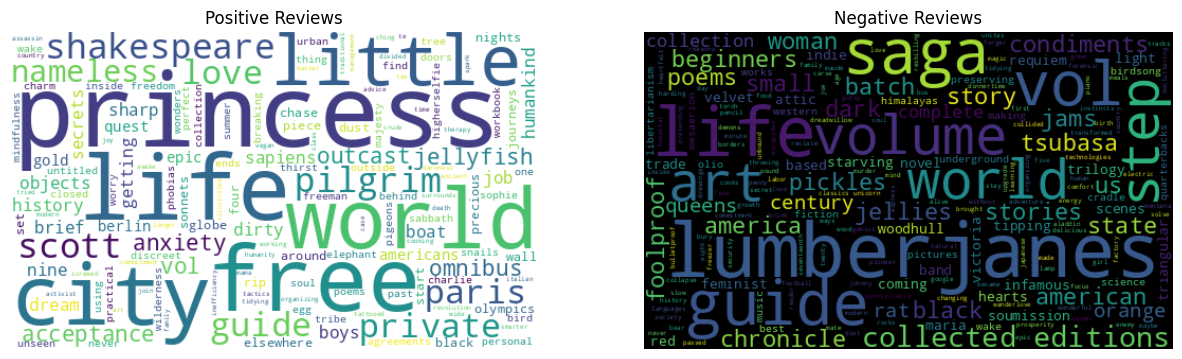

In [65]:
positive_text = " ".join(df[df['Sentiment']==1]['Clean_Review'])
negative_text = " ".join(df[df['Sentiment']==0]['Clean_Review'])

wordcloud_pos = WordCloud(width=500, height=300, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=500, height=300, background_color='black').generate(negative_text)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title("Positive Reviews")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title("Negative Reviews")
plt.axis('off')

plt.show()
